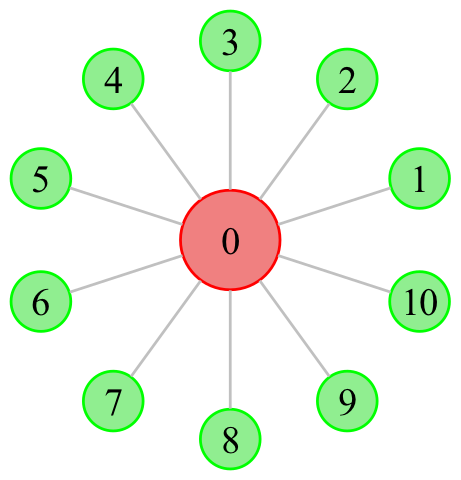

In [83]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tempfile



def plot_star_graph_pygraphviz(G, title):

    # Convert NetworkX graph to PyGraphviz AGraph
    A = to_agraph(G)
    
    # Customize node attributes
    for node in G.nodes():
        n = A.get_node(node)
        if node == 0:
            # Central node: red, larger size, diamond shape
            n.attr['color'] = 'red'
            n.attr['style'] = 'filled'
            n.attr['fillcolor'] = 'lightcoral'
            n.attr['width'] = '0.5'  
            n.attr['height'] = '0.5'  
            n.attr['shape'] = 'circle'
            n.attr['fixedsize'] = 'true'  # Ensures consistent sizing

        else:
            # Leaf nodes: green, smaller size, circle shape
            n.attr['color'] = 'green'
            n.attr['style'] = 'filled'
            n.attr['fillcolor'] = 'lightgreen'
            n.attr['width'] = '0.3'   
            n.attr['height'] = '0.3'  
            n.attr['shape'] = 'circle'
            n.attr['fixedsize'] = 'true'  # Ensures consistent sizing

    
    # Customize edge attributes
    for edge in G.edges():
        e = A.get_edge(edge[0], edge[1])
        e.attr['color'] = 'gray'
        e.attr['penwidth'] = '1'  # Thinner edges for better aesthetics
    
    # Apply the 'twopi' layout for radial arrangement
    A.layout('twopi', args='-Gsize=5,5!')
    
    # Draw the graph to a temporary file and display it
    with tempfile.NamedTemporaryFile(suffix=".png") as tmpfile:
        A.draw(tmpfile.name)
        display(Image(filename=tmpfile.name))

# Plot the star graph

# Number of leaf nodes
leaf_num = 10 # Adjust as needed

# Create a star graph
G = nx.star_graph(leaf_num)

plot_star_graph_pygraphviz(G, "Star Graph Visualization")


### Quantum Walk on a Star Graph using Qiskit
This notebook implements a quantum walk on a star graph using Qiskit. We'll define the necessary functions, set up the quantum circuit, perform the quantum walk, and visualize the results.

In [84]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
backend = AerSimulator()
from math import ceil, log2
from qiskit.circuit.library import MCXGate
import numpy as np
from qiskit.visualization import plot_circuit_layout, plot_histogram
import matplotlib.pyplot as plt


### Define the Star Graph Parameters and create the circuit
Set the number of leaf nodes n and calculate the total number of vertices.

Ancilla Register Fix: Created the ancilla_register once and added it to the circuit. We'll pass it to functions instead of creating it inside them.
Registers:
position_register: Represents the walker's position.
coin_register: Represents the coin state controlling the walker's direction.
ancilla_register: Used for controlled operations.
classical_register: Stores measurement results.

Position qubits: 4, Coin qubits: 4


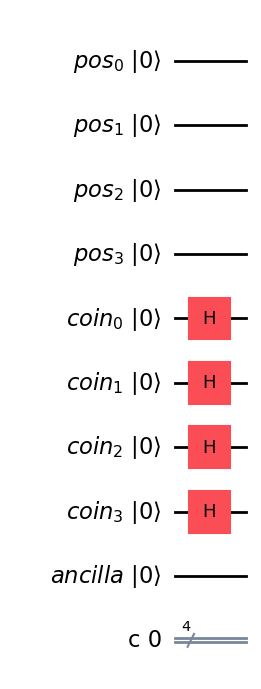

In [94]:
n = 5  # Number of leaf vertices; adjust as needed
num_vertices = n + 1  # Total vertices (1 central + n leaves)

# Calculate the number of qubits needed
num_position_qubits = ceil(log2(num_vertices))  # Position register qubits
num_coin_qubits = ceil(log2(n))  # Coin register qubits

print(f"Position qubits: {num_position_qubits}, Coin qubits: {num_coin_qubits}")

# Create quantum registers
position_register = QuantumRegister(num_position_qubits, name='pos')
coin_register = QuantumRegister(num_coin_qubits, name='coin')
ancilla_register = QuantumRegister(1, name='ancilla')  # Create ancilla register once
classical_register = ClassicalRegister(num_position_qubits, name='c')

# Create the quantum circuit
qc = QuantumCircuit(position_register, coin_register, ancilla_register, classical_register)

# Initialize the coin register in superposition
qc.h(coin_register)

qc.draw(output="mpl", initial_state=True)

### Define the Grover Coin Operator
Grover Coin Operator: Mixes the coin states to create superposition and interference.
Multi-Controlled Gates: Used for applying operations controlled on multiple qubits.

In [95]:
# Cell 3: Define the Grover coin operator function
def grover_coin(qc, coin_qubits):
    """
    Implements the Grover diffusion operator on the coin qubits.
    """
    num_qubits = len(coin_qubits)
    # Apply Hadamard gates to all coin qubits
    qc.h(coin_qubits)
    # Apply X gates to all coin qubits
    qc.x(coin_qubits)
    if num_qubits > 1:
        # Apply multi-controlled x gate
        qc.h(coin_qubits[-1])
        mcx = MCXGate(num_qubits - 1)  # Multi-controlled X gate
        qc.append(mcx, coin_qubits[:-1] + [coin_qubits[-1]])
        qc.h(coin_qubits[-1])
    else:
        # For a single qubit, apply Z gate
        qc.z(coin_qubits[0])
    # Apply X gates to all coin qubits
    qc.x(coin_qubits)
    # Apply Hadamard gates to all coin qubits
    qc.h(coin_qubits)

# Cell 4: Create the Grover coin operator as a gate
def grover_coin_gate(num_qubits):
    """
    Creates a gate representation of the Grover coin operator.
    """
    grover_qc = QuantumCircuit(num_qubits, name='Grover')
    grover_coin(grover_qc, grover_qc.qubits)
    return grover_qc.to_gate()

### Define the Coin Operator Application Function
Ancilla Qubit Usage: Passed ancilla_qubit as an argument instead of creating a new register.
Controlled Operations: The Grover coin operator is applied only if the walker is at the central vertex (|0> state).

In [96]:
# Cell 5: Apply the coin operator conditionally
def apply_coin_operator(qc, position_qubits, coin_qubits, ancilla_qubit):
    """
    Applies the Grover coin operator only when the walker is at the central vertex.
    """
    num_pos_qubits = len(position_qubits)
    num_coin_qubits = len(coin_qubits)

    # Check if the walker is at the central vertex |0>
    # Flip position qubits to check for |0>
    qc.x(position_qubits)
    # Apply multi-controlled X gate controlled on position qubits
    mcx = MCXGate(num_pos_qubits)
    qc.append(mcx, position_qubits[:] + [ancilla_qubit])
    # Flip back position qubits
    qc.x(position_qubits)

    # Apply the Grover coin operator controlled on the ancilla qubit
    grover_gate = grover_coin_gate(num_coin_qubits)
    controlled_grover = grover_gate.control(1)
    qc.append(controlled_grover, [ancilla_qubit] + list(coin_qubits))

    # Reverse the ancilla qubit
    qc.x(position_qubits)
    qc.append(mcx, position_qubits[:] + [ancilla_qubit])
    qc.x(position_qubits)


### Define the Shift Operator
Shift Operator: Swaps the walker's position based on the coin state.
Multi-Controlled Gates: Used to conditionally flip position qubits.

In [97]:
# Cell 6: Define the shift operator function
def shift_operator(qc, position_qubits, coin_qubits):
    """
    Moves the walker based on the coin state by flipping position qubits.
    """
    num_pos_qubits = len(position_qubits)
    num_coin_qubits = len(coin_qubits)

    for i in range(n):
        # Coin state in binary
        coin_state = format(i, f'0{num_coin_qubits}b')
        # Leaf vertex index (i + 1) in binary
        leaf_vertex = format(i + 1, f'0{num_pos_qubits}b')

        # Prepare coin qubit controls
        controls = []
        for idx, bit in enumerate(coin_state):
            if bit == '0':
                qc.x(coin_qubits[idx])  # Flip qubit if bit is '0'
            controls.append(coin_qubits[idx])

        # Flip position qubits based on the coin state
        for idx, bit in enumerate(leaf_vertex):
            if bit == '1':
                qc.mcx(controls, position_register[idx])

        # Reset coin qubits if they were flipped
        for idx, bit in enumerate(coin_state):
            if bit == '0':
                qc.x(coin_qubits[idx])


### Define the Quantum Walk Step Function

In [98]:
# Cell 7: Define the quantum walk step function
def quantum_walk_step(qc, position_qubits, coin_qubits, ancilla_qubit):
    """
    Performs one step of the quantum walk by applying the coin and shift operators.
    """
    apply_coin_operator(qc, position_qubits, coin_qubits, ancilla_qubit)
    shift_operator(qc, position_qubits, coin_qubits)


### Perform the Quantum Walk
1) Quantum Walk Loop: Repeats the quantum walk step for the specified number of steps.
Ancilla Qubit Passing: Passed the ancilla qubit to quantum_walk_step and related functions.
.
2) Measure the Position Register
.
3) Execute the Circuit and Display Results
.
4) Display the results


In [99]:
# 1.Quantum Walk Loop
num_steps = 1  # Adjust as needed
for _ in range(num_steps):
    quantum_walk_step(qc, position_register, coin_register, ancilla_register[0])
qc.barrier()

# 2. Measure the Position Register
qc.measure(position_register, reversed(classical_register))

# 3. Execute the Circuit and Display Results
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
shots = 1024
results = simulator.run(transpiled_qc, shots=shots).result()
counts = results.get_counts(transpiled_qc)

# 4. Display the results
print("\nQuantum Walk Results:")
for outcome in sorted(counts, key=counts.get, reverse=True):
    position = int(outcome, 2)
    print(f"Vertex {position}: {counts[outcome]} occurrences")
    
plot_histogram(counts, title="Quantum Walk on a Star Graph")
plt.show()

print("\nQuantum Walk Results:")
total_counts = sum(counts.values())


Quantum Walk Results:
Vertex 0: 317 occurrences
Vertex 4: 92 occurrences
Vertex 6: 92 occurrences
Vertex 5: 86 occurrences
Vertex 2: 81 occurrences
Vertex 3: 78 occurrences
Vertex 1: 76 occurrences
Vertex 8: 68 occurrences
Vertex 9: 67 occurrences
Vertex 7: 67 occurrences

Quantum Walk Results:


### Display Results with Probabilities

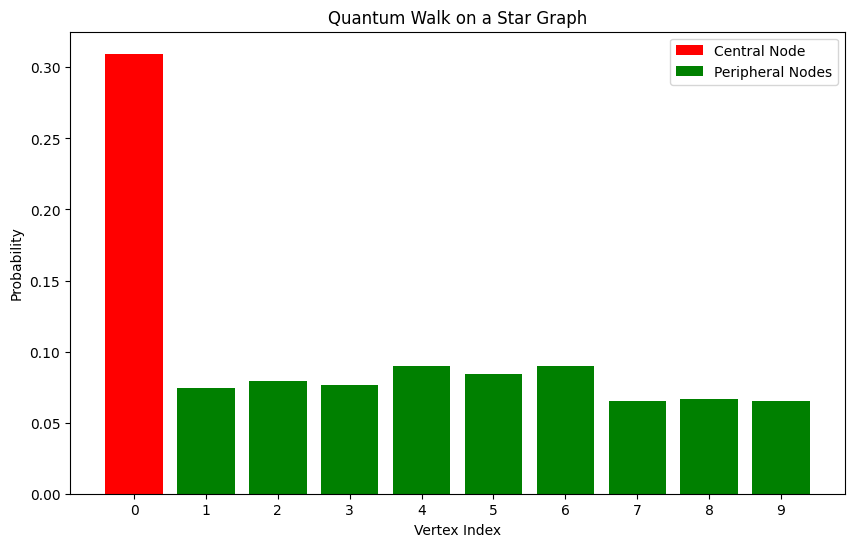

In [100]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Prepare data for plotting
nodes = sorted([int(k, 2) for k in counts.keys()])
probs = [counts[format(node, f'0{num_position_qubits}b')] / total_counts for node in nodes]

# Create color mapping: red for central node, green for peripheral nodes
colors = ['red' if node == 0 else 'green' for node in nodes]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(nodes, probs, color=colors, tick_label=nodes)
plt.xlabel('Vertex Index')
plt.ylabel('Probability')
plt.title('Quantum Walk on a Star Graph')

# Add legend to differentiate central and peripheral nodes
legend_elements = [
    Patch(facecolor='red', label='Central Node'),
    Patch(facecolor='green', label='Peripheral Nodes')
]
plt.legend(handles=legend_elements)

plt.show()

### Draw the circuit (May crush)

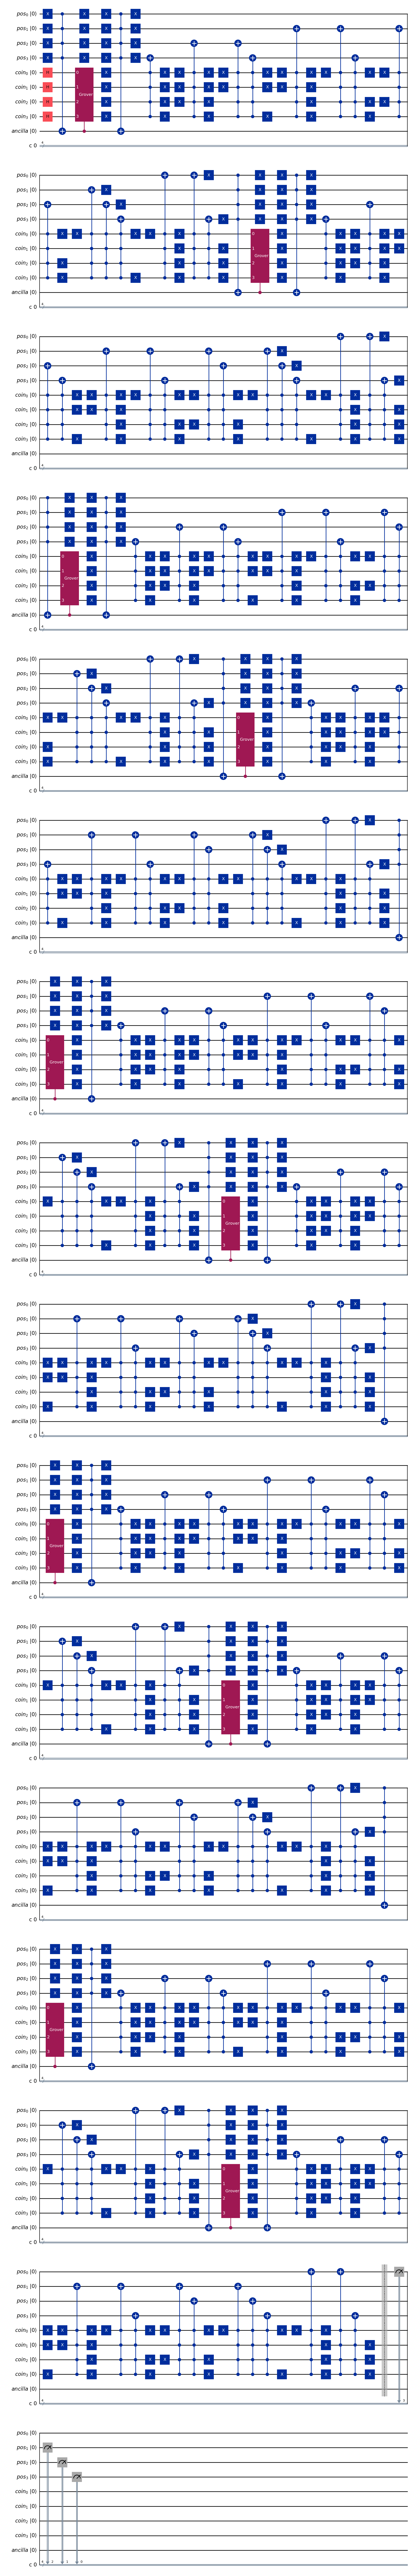

In [101]:
qc.draw(output="mpl", initial_state=True)